# Paralelni algoritmi - drugi projekat


1. **Pristup tekstu sa Wikipedije putem MapReduce programa (6 bodova)**  
Napisati program koji kroz map-reduce paradigmu (upotrebom funkcije *map* iz Python standardne biblioteke i funkcije *reduce* iz paketa *functools*):
  - Za zadatu listu ključnih reči vrši pretragu Wiki stranica i dohvata zadati broj rezultata (naslova stranica)
    Za pristup wiki stranicama se može koristiti python biblioteku [*wikipedia*](https://pypi.org/project/wikipedia/):
```python
import wikipedia
wikipedia.set_lang("sr")
```
```python
def get_pages(query, results=50):
  '''Dohvata naslove zahtevanog broja stranica koje se pojavaljuju kao 
      rezultati pretrage za zadatu kljucnu rec'''
      pages = wikipedia.search(query, results=results)
      return pages
```
  - Paralelizovati rešenje iz prethodne tačke upotrebom funkcija `Pool.map` iz paketa `multiprocessing`
  - Wikipedia API ponekad vrati nevalidne naslove stranica, pa je rezultate neophodno sanitizovati. Napisati map/reduce rešenje koje sanitizuje rezultate iz prethodne tačke. Sanitizacija se može izvesti pokušajem da dohvatanja stranice na osnovu nasova (`wikipedia.page(title)`) i hvatanjem izuzetaka.
  - Napisati map/reduce rešenje koje dohvata sažetke stranica (`page.summary`) iz sanitizovane liste formirane u prethodnoj tački.
  - Wikipedia API ponekad meša stranice na ćiriličnom i latiničnom pismu. Unifikovati tekstive dobijene u prethodnoj tački prevođenjem reči na isto pismo (ćirilično ili latinično)
  ```python
import transliterate
transliterate.translit(word, 'sr')
```
 - Odabrati nekoliko ključnih reči po slobodnom izboru i pokazati da program radi dohvatanjem po dva rezultata za svaku kljunu reč.

2. **Brojanje reci u tesktu i bag-of-words reprezentacija putem MapReduce programa (8 bodova)**  
U ovom zadatku ćemo stranice predstaviti kao *bag-of-words* vektore. *Bag-of-words* reprezentacija se dobija tako što za *sve** reči koje se pojavljuju u svim tekstovima izbrojimo koliko puta se pojavljuju u svakom tekstu. Tekst potom predstvaljamo kao vektor ovih brojeva.   
Na primer, posmatrajmo dva teksta:
``` 
Pera voli da gleda filmove. Mika takođe voli filmove.
``` 
```
Mika voli da gleda i fudbalske utakmice.
```
Reči koje se pojavljuju su:
```
Pera, voli, da, gleda, filmove, Mika, takođe, i, fudbalske, utakmice
``` 
  *Bag-of-words* reprezentacija tekstova je:
```
1, 2, 1, 1, 2, 1, 1, 0, 0, 0
```
odnosno:
```
0, 1, 1, 1, 0, 1, 0, 1, 1, 1
```
U praksi se reči koje se previše često ili previše retko pojavljuju uglavnom odbacuju. 
  - Napisati map/reduce program koji datu listu tesktiva pretvara u *Bag-of-words* reprezentaciju. Pre brojanja reči potrebno je sve reči prevesti u mala ili velika slova (po vašem izboru), te izbaciti interpunkcijske znake i specijalne karaktere (u najmanju ruku sledeći skup `\n, \t, =, -, (, ), _`). Odbaciti reči koje se pojavljuju veoma često u većini tekstovima (nalaze se u 90% najčešćih reči u bar 90% tekstova), ili se pojavljuju u manje od 1% tekstova. Ovu obradu izvesti kroz posebne map/reduce korake.
  - Ručno uneti nekoliko tekstova po slobodnom izboru i pokazati da program radi.

3. **K-means klastersanje putem MapReduce programa (5 bodova)**   
Napisati map/reduce program koji vrši k-means klasterisanje liste vektora.
Nasumično generisati podatke iz nekoliko normalnih raspodela u dve dimenzije i pokazati da algoritam radi (videti vežbe za primer). 

4. **Primena rešenja  (6 bodova)**  
Povezati kod iz zadataka 1-3 kojim se Wiki na srpskom jeziku pretražuje za sledeći skup ključnih reči `['Beograd', 'Prvi svetski rat', 'Protein', 'Mikroprocesor', 'Stefan Nemanja', 'Košarka']`, za svaku dohvata po 50 rezultata, stranice prevode u *bag-of-words* reprezentaciju, i vrši njihovo klasterisanje. 
U kojom meri klasteri odgovaraju temama prema kojima su stranice dohvatane?

In [ ]:
!pip install wikipedia
!pip install cyrtranslit

In [ ]:
''' Tačka 1
    #proces paralelizovati upotrebom Poll.map()
    #dohvatiti odr br stranica 
    #izbaciti nevalidne naslove
    #sažeci stranica iz prečišćene liste
    #prevesti na isto pismo
'''

import wikipedia
wikipedia.set_lang("sr")
from functools import reduce
import cyrtranslit
import multiprocessing as mp
from itertools import starmap

pool = mp.Pool(mp.cpu_count())

def get_pages(query, results=3):
 pages = wikipedia.search(query, results)
 return [query, list(pages)]

#map_pages = pool.map(get_pages, key_words)

def sanitize(array, pages):
  for arr in pages[1]:
    try: 
      wikipedia.page(arr)
      array += [[pages[0], arr]] 
    except: continue   
  return array

#map_sanitized = reduce(sanitize, map_pages, [])

def get_summary(key, value):
  return [key, [str(value), wikipedia.summary(value)]]

#map_summary = list(starmap(get_summary, map_sanitized))

def translate(text):
  return cyrtranslit.to_latin(text)

def map_translate(key, value):
  return [translate(key), translate(value[0]), translate(value[1])]

#map_translated = list(starmap(map_translate, map_summary))


def run_point1(key_words):
  return list(starmap(map_translate, starmap(get_summary, reduce(sanitize, pool.map(get_pages, key_words),[]))))


map_final = run_point1(['politika', 'sport'])

for item in map_final:
  print(item)

['politika', 'Spoljna politika', 'Državana spoljna politika su ciljevi i aktivnosti vezani za interakcije sa drugim državama, bilo bilateralno ili putem multilateralnih platformi. Enciklopedija Britanika primećuje da na spoljnu politiku neke zemlje mogu uticati „domaća razmatranja, politika ili ponašanje drugih država ili planovi za unapređenje određenih geopolitičkih rešenja”.']
['politika', 'Politika (novine)', 'Politika je dnevni list koji izlazi u Srbiji više od jednog veka. Novine je pokrenuo Vladislav Ribnikar 25. januara 1904. godine u Beogradu, gde je i danas sedište redakcije lista.']
['politika', 'Javna politika', 'Javna politika je principijelni vodič za postupanje upravnih izvršnih grana države u donošenju odluka, u skladu sa zakonima i propisima.']
['sport', 'Nova sport', 'Nova Sport srpski je pretplatnički televizijski kanal koji se emituje od 4. decembra 2019. godine i u vlasništvu je preduzeća United Group. Kanal je specijalizovan za prenos najvažnijih sportskih događaj

In [ ]:
'''Tačka 2
  #bag of words reprezentacija tekstova

  #prevesti u velika slova
  #izbaciti interpunkcijske znake
  #napraviti bag of words
  #napraviti vektore
  #izbaciti najčešće reči - nalaze se u 10% najčešćih reči u 90% tekstova
  #izbaciti najređe reči 1% 
'''
from functools import reduce

texts = ["Krivično delo je društveno opasno delo koji pravni poredak zabranjuje pod pretnjom primene krivične sankcije. U teoriji krivično pravo krivično delo je definisano na različite načine koje možemo svrstati na dva shvatanja pojma krivičnog dela: formalističko i materijalističko. U Krivičnom zakonu Republike Srpske krivično delo je opisano kao protivpravno delo kojim se povređuju ili ugrožavaju zaštićene vrednosti i koje je zbog svoje opasnosti, u zakonu određeno kao krivično delo i za njega propisana krivična sankcija.",
         "Marksizam, koji se temelji na engleskoj političkoj ekonomiji, francuskom utopijskom socijalizmu i njemačkoj idealističkoj filozofiji iz prve polovice 19. vijeka, nastoji dati kritiku društva koja je istovremeno naučna i revolucionarna. Marksizam historiju tumači kroz sukob povlaštenih i potlačenih društvenih klasa, te smatra da će svi društveni problemi biti riješeni stvaranjem besklasnog društva zvanog komunizam. Kao prijelazna faza između kapitalizma - koga marksisti smatraju posljednjim stadijem klasnog društva - i komunizma bi se trebao uspostaviti socijalizam u kome bi postepeno trebalo biti ukinuto privatno vlasništvo nad sredstvima za proizvodnju."]


def make_text(array, text):
  arr = []
  for word in text.split():
    word = word.lstrip('.,()?![]-_ ').rstrip('.,()?![]-_ ').upper()
    if word.isalnum(): arr += [word]
  return array + [arr]

def make_bag(array, text):
  for word in text:
    word = word.lstrip('.,()?![]')
    word = word.rstrip('.,()?![]')
    if word not in array:
      array += [word]    
  return array

texts = reduce(make_text, texts, [])
bag_of_words = reduce(make_bag, texts, [])

def make_vectors(array, text):
  arr = []
  for word in array[0]:
    arr += [text.count(word)]
  return array + [arr]

vectors = reduce(make_vectors, texts, [bag_of_words])

def clean_vectors(array, vector):
  if type(vector[0]) == str: 
    return array
  return array + [vector]

vectors_c = reduce(clean_vectors, vectors, [])
print(vectors_c)

def sum_words(s, vector):
  for v in vector: s += v
  return s

sum = reduce(sum_words, vectors_c , 0)
print(sum)

def transpose(array, vector):
  if len(array) == 0:
    for i in range(len(vector)): array += [[]]
  for i in range(len(vector)):
    array[i] += [vector[i]]
  return array


def mark_often(array, vector):
  arr = []
  to_rtn = []
  words = 0
  for i in range(len(vector)):
    if vector[i] > 0: words += vector[i] 
    arr += [[i, vector[i]]]
    to_rtn += [[False, vector[i]]]
  arr = sorted(arr, key=lambda x: x[1], reverse = True)
  for i in range(round(words*0.1)):
    index = arr[i][0]
    to_rtn[index][0] = True
  return array + [to_rtn]    

vectors_marked = reduce(mark_often, vectors_c, [])
print(vectors_marked)
vectors_marked_t = reduce(transpose, vectors_marked, [])
print(vectors_marked_t)

def reduce_often_rare(array, vector):
  sum_often = 0
  sum_rare = 0
  all_words = array[0]
  for v in vector:
    if v[0]: sum_often+=1
    sum_rare += v[1]
  if sum_often / len(vector) > 0.9: 
    #print("often")
    return array 
  if sum_rare / all_words < 0.001:
    #print("Rare")
    return array
  return array + [vector]

vector_reduced_t = reduce(reduce_often_rare, vectors_marked_t, [sum])
print(vector_reduced_t)

def often_clean(array, vector):
  if type(vector) == int: return array
  arr = []
  for v in vector:
    arr+= [v[1]]
  return array + [arr]

vector_clean_t = reduce(often_clean, vector_reduced_t, [])
print(vector_clean_t)
print(len(vector_clean_t))
vector_final = reduce(transpose, vector_clean_t, [])
print(vector_final)

def run_point2(texts):
  texts = reduce(make_text, texts, [])
  bag_of_words = reduce(make_bag, texts, [])
  #print(bag_of_words)
  #print(len(bag_of_words))
  vectors = reduce(clean_vectors, reduce(make_vectors, texts, [bag_of_words]), [])
  sum = reduce(sum_words, vectors, 0)
  #print(sum)
  return reduce(transpose, reduce(often_clean, reduce(reduce_often_rare, reduce(transpose, reduce(mark_often, vectors, []), []), [sum]), []), [])


#vector_final = run_point2(texts = texts)

print(vector_final)


In [ ]:
'''
Tačka 3

'''
import numpy as np
from functools import reduce


def map_centroids(centroid):
  return [centroid]

#centroids_m = list(map(map_centroids, centroids))

def only_centroids(c):
  return c[0]

def assign_datapoints(centroids, datapoint):
  only_c = list(map(only_centroids, centroids))
  distance = np.sqrt(((only_c - datapoint)**2).sum(axis=1))
  ind = np.argmin(distance)
  centroids[ind] += [[datapoint]]
  return centroids

#centroids_a = reduce(assign_datapoints, data, centroids_m)



def assign_new_centroid(centroid):
  old_c = centroid[0]
  cluster_size = len(centroid) - 1
  new_c = (sum(centroid) - old_c)/cluster_size
  return [np.array(new_c[0])]

#centroids_n = list(map(assign_new_centroid, centroids_a))

def run_point3(data, k):
  np.random.seed(3)
  centroids = np.random.uniform(-2, 3, (k, 2))
  centroids = list(map(map_centroids, centroids))
  for _ in range(200):
    centroids = reduce(assign_datapoints, data, centroids)
    centroids = list(map(assign_new_centroid, centroids))
  return centroids



[-1.10159581 -1.41629565]
[ 2.47805355 -0.52948414]


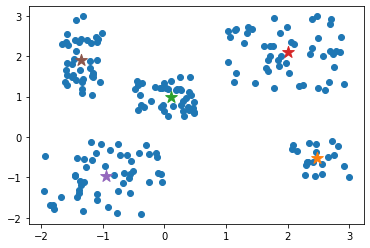

In [ ]:
import matplotlib.pyplot as plt

np.random.seed(3)
data = -2 * np.random.rand(200, 2)

data1 = 1 + 2 * np.random.rand(50, 2)
data2 = 0.5 + np.random.rand(40, 2)
data2[:, 0] = data2[:, 0] - 1

data3 = 0.5 + np.random.rand(40, 2)
data3[:, 0] = (data3[:, 0] - 3)/1.5
data3[:, 1] = data3[:, 1] * 2

data4 = np.random.rand(20, 2)
data4[:, 0] = data4[:, 0] +2
data4[:, 1] = data4[:, 1]-1

data[50:100, :] = data1
data[100:140, :] = data2
data[140:180, :] = data3
data[180:200, :] = data4


centroids = run_point3(data, 5)

plt.scatter(data[ : , 0], data[ :, 1])
for c in centroids:
  cn = c[0]
  plt.scatter(*cn, marker='*', s=150)

In [ ]:
'''
Tačka 4
  #Dohvatiti 50 naslova za ključne reči ['Beograd', 'Prvi svetski rat', 'Protein', 'Mikroprocesor', 'Stefan Nemanja', 'Košarka']
  #Prevođenje u bag-of-words
  #Klasterisanje
'''
key_words = ['Beograd', 'Prvi svetski rat', 'Protein', 'Mikroprocesor', 'Stefan Nemanja', 'Košarka']

point1 = run_point1(key_words)
for item in point1:
  print(item)

def get_texts(page):
  return page[2]

texts = list(map(get_texts, point1))

vectors = run_point2(texts)

for v in vectors:
  print(v)

